In [1]:
!pip install netCDF4
!pip install requests beautifulsoup4
!pip install scipy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 24.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 20.9 MB/s eta 0:00:00


download data from 2020-2025 from a given link

In [2]:
import os
import requests
import numpy as np
from bs4 import BeautifulSoup
from concurrent.futures import ThreadPoolExecutor

# BASE_URL = input("Provide the link to databases:")
# YERAS = input("Provide the years of data to download(example:2020,2025 to get dataset from 2020-2025):")


# if(YERAS):
#   YERAS = range([int(year) for year in YERAS.split(',')])
# else:
YEARS = range(2020, 2025)  # 2020-2024

SAMPLE_DAYS_PER_MONTH = 31
# if(BASE_URL):
#     print("BASE_URL")
#     pass
# else:
BASE_URL = "https://data.ngdc.noaa.gov/platforms/solar-space-observing-satellites/goes/goes16/l1b/seis-l1b-sgps"



def create_year_folders():

    for year in YEARS:
        os.makedirs(f"goes16_data/{year}", exist_ok=True)

def get_monthly_files(year, month):

    url = f"{BASE_URL}/{year}/{month:02d}/"
    try:
        response = requests.get(url, timeout=10)
        response.raise_for_status()
        soup = BeautifulSoup(response.text, "html.parser")
        return [link['href'] for link in soup.find_all("a")
               if link['href'].endswith('.nc') and 'ops_seis-l1b-sgps' in link['href']]
    except Exception as e:
        print(f"Error fetching {year}-{month:02d}: {str(e)}")
        return []

def download_file(year, month, day_file):

    day = day_file[20:22]
    url = f"{BASE_URL}/{year}/{month:02d}/{day_file}"
    local_path = f"goes16_data/{year}/{day_file}"

    if not os.path.exists(local_path):
        try:
            with requests.get(url, stream=True, timeout=15) as response:
                response.raise_for_status()
                with open(local_path, 'wb') as f:
                    for chunk in response.iter_content(chunk_size=8192):
                        f.write(chunk)
            print(f"Downloaded {year}/{month:02d}/{day_file}")
            return True
        except Exception as e:
            print(f"Failed {year}/{month:02d}/{day_file}: {str(e)}")
            return False
    return True

def process_year_month(year, month):

    files = get_monthly_files(year, month)
    if not files:
        return 0

    # Sample evenly across the month
    sample_indices = np.linspace(0, len(files)-1, dtype=int)
    sampled_files = [files[i] for i in sample_indices]

    # Download sampled files in parallel
    with ThreadPoolExecutor(max_workers=5) as executor:
        results = list(executor.map(lambda f: download_file(year, month, f), sampled_files))

    return sum(results)

def main():
    create_year_folders()
    total_downloaded = 0

    for year in YEARS:
        for month in range(1, 13):
            downloaded = process_year_month(year, month)
            total_downloaded += downloaded

    print(f"\nDownload complete {total_downloaded} files saved in year folders.")

if __name__ == "__main__":
    main()

Downloaded 2020/01/ops_seis-l1b-sgps_g16_d20200101_v0-0-0.nc
Downloaded 2020/01/ops_seis-l1b-sgps_g16_d20200101_v0-0-0.nc
Downloaded 2020/01/ops_seis-l1b-sgps_g16_d20200103_v0-0-0.nc
Downloaded 2020/01/ops_seis-l1b-sgps_g16_d20200104_v0-0-0.nc
Downloaded 2020/01/ops_seis-l1b-sgps_g16_d20200104_v0-0-0.nc
Downloaded 2020/01/ops_seis-l1b-sgps_g16_d20200105_v0-0-0.nc
Downloaded 2020/01/ops_seis-l1b-sgps_g16_d20200106_v0-0-0.nc
Downloaded 2020/01/ops_seis-l1b-sgps_g16_d20200107_v0-0-0.nc
Downloaded 2020/01/ops_seis-l1b-sgps_g16_d20200108_v0-0-0.nc
Downloaded 2020/01/ops_seis-l1b-sgps_g16_d20200108_v0-0-0.nc
Failed 2020/01/ops_seis-l1b-sgps_g16_d20200109_v0-0-0.nc: HTTPSConnectionPool(host='data.ngdc.noaa.gov', port=443): Read timed out. (read timeout=15)
Downloaded 2020/01/ops_seis-l1b-sgps_g16_d20200111_v0-0-0.nc
Failed 2020/01/ops_seis-l1b-sgps_g16_d20200107_v0-0-0.nc: HTTPSConnectionPool(host='data.ngdc.noaa.gov', port=443): Read timed out.
Failed 2020/01/ops_seis-l1b-sgps_g16_d20200110_

slow(but more intuitive) version of calculating the sum of the 1 second fluxes

In [ ]:
from netCDF4 import Dataset
import numpy as np
from pathlib import Path
from collections import defaultdict

# Configuration
BASE_DIR = '/content/goes16_data/'
YEARS = range(2020, 2025)
# SECONDS_PER_5MIN = 300
# SOLID_ANGLES = {"T1": 1.84, "T2": 1.84, "T3": 6.28}

# def decode_energy_label(label):
#     """Convert netCDF energy label to numerical bounds with proper parsing"""
#     if isinstance(label, np.ndarray):
#         label_str = b''.join(label).decode('utf-8').strip('\x00')
#     else:
#         label_str = label.decode('utf-8').strip('\x00')


#     energy_part = label_str.split(':')[-1].replace("MeV", "").strip()
#     e_low, e_high = map(float, energy_part.split('-'))
#     return (e_low, e_high)


# cumulative_fluence = defaultdict(float)


file_paths = []
for year in YEARS:
    year_dir = Path(BASE_DIR) / str(year)
    if year_dir.exists():
        file_paths.extend(sorted(year_dir.glob('*.nc')))


for_all_files_binsum = [[[0,0,0,0,0,0],[0,0],[0,0,0,0,0]],[[0,0,0,0,0,0],[0,0],[0,0,0,0,0]]]
for file_path in file_paths:
  try:
   with Dataset(file_path, 'r') as nc:

          binsum =[[[0,0,0,0,0,0],[0,0],[0,0,0,0,0]],[[0,0,0,0,0,0],[0,0],[0,0,0,0,0]]]

          for t in range(3):
            flux_var = nc[f'T{t+1}_DifferentialProtonFluxes']
            flux_data = np.ma.filled(flux_var[:], fill_value=0.0)
            for i in range(len(flux_data)):
              # for j in range(len(flux_data[0])):
                for k in range(len(flux_data[i][0])):
                  # if(flux_data[i,0,k]!=0):#(flux_data[i,0,k] > 0) & (flux_data[i,0,k] < 1e30)
                      binsum[0][t][k]+=flux_data[i,0,k]
                      binsum[1][t][k]+=flux_data[i,1,k]
                  # else:
                      # if(flux_data[i,1,k]>0):
                        # binsum[t][k]+=flux_data[i,1,k]
          print("number of protons per cm per sr per kev in a day")
          for i in range(len(for_all_files_binsum)):
              for j in range(len(for_all_files_binsum[i])):
                for k in range(len(for_all_files_binsum[i][j])):
                  for_all_files_binsum[i][j][k]= for_all_files_binsum[i][j][k]+binsum[i][j][k]
          print(binsum)
          # print(binsum*(365*5*4*3000))
  except Exception as e:
          print(f"Error processing file {file_path}: {str(e)}")
print("number of protons per cm per sr per kev in all days")
print(for_all_files_binsum)

optimized version of summing the 1 second fluxes to get flux for the 5 year period(errors are for a few files not present in the 5 year observations)

In [32]:
from netCDF4 import Dataset
import numpy as np
from pathlib import Path
from collections import defaultdict

# Configuration
BASE_DIR = '/content/goes16_data/'
YEARS = range(2020, 2025)

# Prepare a dict to store cumulative sums for each telescope
# Keys: 'T1','T2','T3'; Values: np.ndarray shape (2, N_bins)
total_fluence = {}

# Dynamically determine energy-bin counts from first file
first_file = None
for yr in YEARS:
    d = Path(BASE_DIR) / str(yr)
    if d.exists():
        files = sorted(d.glob('*.nc'))
        if files:
            first_file = files[0]
            break
if first_file is None:
    raise RuntimeError("No netCDF files found in given directory range.")

with Dataset(first_file, 'r') as nc:
    for t in range(3):
        var = nc[f'T{t+1}_DifferentialProtonFluxes']
        _, _, nbin = var.shape
        total_fluence[f'T{t+1}'] = np.zeros((2, nbin), dtype=np.float64)

# Gather all files
file_paths = []
for year in YEARS:
    d = Path(BASE_DIR) / str(year)
    if d.exists():
        file_paths.extend(sorted(d.glob('*.nc')))

# Sum across time dimension for each file (vectorized) and accumulate
def accumulate_file(fp):
  try:
    with Dataset(fp, 'r') as nc:

        for t in range(3):
            tel = f'T{t+1}'
            flux = nc[f'{tel}_DifferentialProtonFluxes'][:]  # shape (86400,2,nbin)
            # convert masked to zero and sum over time axis
            daily = np.ma.filled(flux, 0.0).sum(axis=0)  # shape (2,nbin)
            total_fluence[tel] += daily
  except Exception as e:
          print(f"Error processing file {fp}: {str(e)}")

for fp in file_paths:
    accumulate_file(fp)

# total_fluence now holds summed fluence per cm^2 sr keV over all days/files
# Example: print for T1 +X sensor (index 1)
print(total_fluence)

Error processing file /content/goes16_data/2020/ops_seis-l1b-sgps_g16_d20200110_v0-0-0.nc: [Errno -101] NetCDF: HDF error: '/content/goes16_data/2020/ops_seis-l1b-sgps_g16_d20200110_v0-0-0.nc'
Error processing file /content/goes16_data/2021/ops_seis-l1b-sgps_g16_d20210306_v0-0-0.nc: [Errno -51] NetCDF: Unknown file format: '/content/goes16_data/2021/ops_seis-l1b-sgps_g16_d20210306_v0-0-0.nc'
Error processing file /content/goes16_data/2021/ops_seis-l1b-sgps_g16_d20210801_v0-0-0.nc: [Errno -101] NetCDF: HDF error: '/content/goes16_data/2021/ops_seis-l1b-sgps_g16_d20210801_v0-0-0.nc'
Error processing file /content/goes16_data/2021/ops_seis-l1b-sgps_g16_d20210807_v0-0-0.nc: [Errno -101] NetCDF: HDF error: '/content/goes16_data/2021/ops_seis-l1b-sgps_g16_d20210807_v0-0-0.nc'
Error processing file /content/goes16_data/2023/ops_seis-l1b-sgps_g16_d20230123_v0-0-0.nc: [Errno -101] NetCDF: HDF error: '/content/goes16_data/2023/ops_seis-l1b-sgps_g16_d20230123_v0-0-0.nc'
Error processing file /con

if optimized version is used, convert it to [
    [[], [], []],
    [[], [], []]  ] not to change the code below

In [ ]:
import numpy as np

# Assuming total_fluence is already defined as in your example
# Initialize the desired structure
sum_fluence = [
    [[], [], []],  # For -X direction (index 0)
    [[], [], []]   # For +X direction (index 1)
]

# Map each telescope to its corresponding index in the nested list
telescope_mapping = {
    'T1': 0,
    'T2': 1,
    'T3': 2
}

# Iterate over each telescope and populate the nested list
for telescope, data in total_fluence.items():
    tel_index = telescope_mapping[telescope]
    for direction in range(2):  # 0 for -X, 1 for +X
        sum_fluence[direction][tel_index] = data[direction].tolist()

# Now sum_fluence is in the desired format
print(sum_fluence)


total flux for 5 years

In [14]:
sum_f=0
for i in range(len(for_all_files_binsum)):
              for j in range(len(for_all_files_binsum[i])):
                  for k in range(len(for_all_files_binsum[i][j])):
                    sum_f+= float(for_all_files_binsum[i][j][k])

print(sum_f)

26957327.549860165


calculated fluence for 5 years per energy range with X and +X separate

In [15]:
sum_fluence=[[[0,0,0,0,0,0],[0,0],[0,0,0,0,0]],[[0,0,0,0,0,0],[0,0],[0,0,0,0,0]]]
energies = [[[(1.0, 1.9), (1.9, 2.3), (2.3, 3.4), (3.4, 6.5), (6.5, 12.0), (12.0, 25.0)],[(25.0, 40.0), (40.0, 80.0)], [(83.0, 99.0), (99.0, 118.0), (118.0, 150.0), (150.0, 275.0), (275.0, 500.0)]],[[(1.0, 1.9), (1.9, 2.3), (2.3, 3.4), (3.4, 6.5), (6.5, 12.0), (12.0, 25.0)],[(25.0, 40.0), (40.0, 80.0)], [(83.0, 99.0), (99.0, 118.0), (118.0, 150.0), (150.0, 275.0), (275.0, 500.0)]]]
for i in range(len(for_all_files_binsum)):
              for j in range(len(for_all_files_binsum[i])):
                for k in range(len(for_all_files_binsum[i][j])):
                  delta_E = (energies[i][j][k][1] - energies[i][j][k][0]) * 1000
                  sum_fluence[i][j][k]+= float(for_all_files_binsum[i][0][k])*float(4*np.pi)* delta_E

print(sum_fluence)

[[[78249688008.4874, 12053472253.980904, 18928125815.103985, 17979293468.202225, 14843554004.93746, 3244525909.649709], [1304161466808.1235, 1205347225398.0908], [1391105564595.3318, 572539932064.0931, 550636387348.4795, 724971510814.6058, 607236300201.9869]], [[116960266326.33675, 17365007649.761086, 17505766263.127254, 16343654396.54711, 5007510463.65097, 2329525319.072798], [1949337772105.6128, 1736500764976.109], [2079293623579.3203, 824837863363.6517, 509258654927.3383, 659018322441.4158, 204852700785.7215]]]


sum of X and +X per energy range

In [17]:

sum_x_fluence=[]
for t in range(len(sum_fluence[0])):
    combined = []

    for k in range(len(sum_fluence[0][t])):
        combined.append(
            sum_fluence[0][t][k]  # –X
            + sum_fluence[1][t][k]  # +X
        )
    sum_x_fluence.append(combined)

print(sum_x_fluence)

[[195209954334.82416, 29418479903.74199, 36433892078.23124, 34322947864.749336, 19851064468.588432, 5574051228.722507], [3253499238913.7363, 2941847990374.1997], [3470399188174.6523, 1397377795427.7449, 1059895042275.8179, 1383989833256.0215, 812089000987.7085]]


input spectrum generation

In [41]:
# Continue from your existing sum_fluence calculation
gamma = 2.7  # From NASA AP8 model for trapped protons
spectrum = []

# Process each energy band group (T1, T2, T3)
for i in range(len(sum_x_fluence)):
    for j in range(len(sum_x_fluence[i])):
        e_low, e_high = energies[0][i][j]
        total_fluence = sum_x_fluence[i][j]

        # Create 10 logarithmic sub-bins per energy band
        sub_bins = np.logspace(np.log10(e_low), np.log10(e_high), num=11)
        mid_points = (sub_bins[:-1] + sub_bins[1:]) / 2

        # Calculate power-law weights
        weights = mid_points ** -gamma
        weights /= weights.sum()  # Normalize within band

        # Distribute fluence according to power law
        for energy, weight in zip(mid_points, weights):
            spectrum.append((energy, total_fluence * weight))

# Convert to probabilities
energies_list, counts = zip(*spectrum)
total_counts = sum(counts)
probabilities = [c/total_counts for c in counts]

# Write to file with scientific formatting
with open('input_spectrum.txt', 'w') as f:
    f.write("Energy (MeV)\tProbability\n")
    for energy, prob in sorted(zip(energies_list, probabilities), key=lambda x: x[0]):
        f.write(f"{energy:.6f}\t{prob:.6e}\n")

# Verification
print(f"Total probability: {sum(probabilities):.2f}")
print(f"Energy range: {min(energies_list):.1f}-{max(energies_list):.1f} MeV")
print(f"Number of bins: {len(energies_list)}")
print(f"energy_spectrum.txt created")


Total probability: 1.00
Energy range: 1.0-485.5 MeV
Number of bins: 130
energy_spectrum.txt created


total sum for all energies, total fluence in 5 years on cm^2 area

In [19]:
#when summing +x
total_fluence=0
for i in range(len(sum_fluence)):
              for j in range(len(sum_fluence[i])):
                for k in range(len(sum_fluence[i][j])):
                  total_fluence+= float(sum_fluence[i][j][k])

print(total_fluence)

14639908479288.738


In [25]:
total_fluence*0.0001*3#0.1mm 0.1mm but too big for grasshopper, so scale to smaller area

4391972543.786622

In [26]:
total_fluence*1e-6*3#0.01mm 0.01mm

43919725.43786621

In [ ]:
total_fluence*1e-8*3#0.001mm 0.001mm

after doing all the steps above give the number of protons and the input_spectrum.txt to grasshopper to simulate the radiation and then put the file in the code below

grasshopper output analysis

N_atoms: 42455166.33619738
E_dep_eV: 1522460.1662700002
DPA: 0.0007968982590108877
delta_rho: 7.968982590108876e-10
=== NRT Model Results (100×100×10 nm³ Cu) ===
DPA (NRT): 7.969e-04
Resistance change: 4.743442017921941%


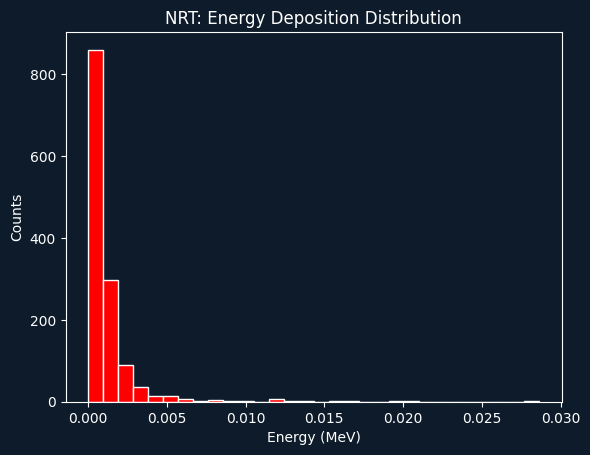

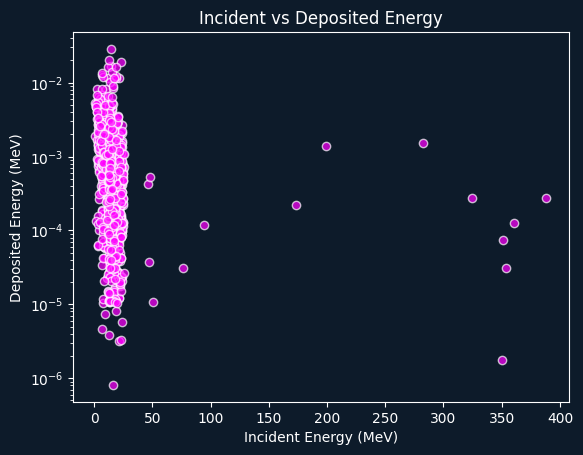

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

def apply_white_theme():
    plt.rcParams.update({
        'figure.facecolor': 'white', 'axes.facecolor': 'white',
        'axes.edgecolor': 'black', 'axes.labelcolor': 'black',
        'xtick.color': 'black', 'ytick.color': 'black',
        'text.color': 'black', 'axes.titlecolor': 'black',
        'grid.color': 'gray', 'grid.alpha': 0.3,
    })
def apply_dark_blue_theme():
    plt.rcParams.update({
        'figure.facecolor': '#0d1b2a',
        'axes.facecolor': '#0d1b2a',
        'axes.edgecolor': 'white',
        'axes.labelcolor': 'white',
        'xtick.color': 'white',
        'ytick.color': 'white',
        'text.color': 'white',
        'axes.titlecolor': 'white',
        'grid.color': 'gray',
        'grid.alpha': 0.3,
    })
# --- File Loading ---
df = pd.read_csv(
    '/content/out_mycalc_15_w001_c100_50_mix.dat',
    sep='\t',
    names=[
        'E_beam', 'E_incident', 'E_deposited', 'x_incident', 'y_incident',
        'z_incident', 'theta', 'Time', 'EventID', 'TrackID', 'ParticleID',
        'ParticleName', 'CreatorProcessName', 'IsEdepositedTotalEntry',
        'IsSurfaceHitTrack', 'detector#'
    ],
    skiprows=1
)

# --- Data Filtering ---
df_cu = df[(df['detector#'] == 0) & (df['E_deposited'] > 0) & (df['E_incident'] > 0) & (df['ParticleName'] == 'proton')]
# print(df_cu)
# --- Physics Constants (NRT) ---
rho_0 = 1.68e-8  # Cu resistivity [Ω·m] (NIST SRD 126)
eta = 0.8         # NRT efficiency factor
E_d = 18.0        # Displacement threshold 30[eV] (ASTM E521-16) worst case 18
alpha = 1e-6    # Δρ/DPA [Ω·m/DPA] (JPS Conf. Proc. 33)

# --- Geometry ---
L = 100e-9  # Length [m]
W = 100e-9  # Width [m]
T = 50e-9   # Thickness [m]
A = W * T   # Cross-section [m²]
V = L * A   # Volume [m³]

# Atomic density
rho_Cu = 8960         # Density [kg/m³]
M_Cu = 0.063546       # Molar mass [kg/mol]
N_atoms = (rho_Cu * V / M_Cu) * 6.022e23  # Atoms in volume
print(f"N_atoms: {N_atoms}")
# --- NRT Damage Calculation ---
E_dep_eV = (df_cu['E_deposited']).sum() * 1e6  # MeV→eV
print(f"E_dep_eV: {E_dep_eV}")
DPA = (0.8 * E_dep_eV) / (2 * E_d * N_atoms)  # NRT formula
print(f"DPA: {DPA}")
delta_rho = alpha * DPA  # Resistivity change
print(f"delta_rho: {delta_rho}")
# --- Resistance Change ---
R0 = rho_0 * L / A
R_new = (rho_0 + delta_rho) * L / A
delta_R_pct = ((R_new - R0)/R0) * 100

# --- Output ---
print("=== NRT Model Results (100×100×10 nm³ Cu) ===")
print(f"DPA (NRT): {DPA:.3e}")
print(f"Resistance change: {delta_R_pct}%")

# --- Visualization ---
apply_dark_blue_theme()
plt.hist(df_cu['E_deposited'], bins=30, color='red', edgecolor='white')
plt.title('NRT: Energy Deposition Distribution')
plt.xlabel('Energy (MeV)')
plt.ylabel('Counts')
plt.show()
plt.scatter(df_cu['E_beam'], df_cu['E_deposited'],
            color='magenta', alpha=0.7, edgecolor='white')
plt.yscale('log')
plt.title('Incident vs Deposited Energy')
plt.xlabel('Incident Energy (MeV)')
plt.ylabel('Deposited Energy (MeV)')
plt.show()
